In [28]:
import mdtraj as md
import os, sys, importlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def source_module_attr(module_file:str, attr_name:str, local_attr_name:str = None):
    
    """to add a module from a user defined python script into the local name space"""
    

    if local_attr_name is None:
        local_attr_name = attr_name
    
    if len(module_file.split("/")) == 1 or module_file.split("/")[-2] == ".":
        module_dir = os.getcwd()
    else:
        module_dir = "/".join(module_file.split("/")[:-1])

    sys.path.insert(0, module_dir)
    
    module = importlib.import_module(module_file.split("/")[-1][:-3])
    
    g = globals()
    g[local_attr_name] = getattr(module, attr_name)
    
    pass

def source_module(module_file: str, local_module_name: str = None):

    """to add a module from a user defined python script into the local name space"""

    #
    if local_module_name is None:
        local_module_name = module_file.split("/")[-1].replace(".py", "")

    if len(module_file.split("/")) == 1 or module_file.split("/")[-2] == ".":
        module_dir = os.getcwd()
    else:
        module_dir = "/".join(module_file.split("/")[:-1])

    sys.path.insert(0, module_dir)

    module = importlib.import_module(module_file.split("/")[-1].replace(".py", ""))

    g = globals()
    g[local_module_name] = module

    pass


#source modules and classes being developed 
source_module_attr("./writhe.py", "Writhe") #class
source_module_attr("./writhe_graph.py", "WritheGraph") #class
source_module_attr("./lightning_graph.py", "GraphDataSet") #class
source_module("./visualize.py") #module
source_module("./utils.py") #module
source_module_attr("/home/t/Downloads/msmtool.py", "calc_SA","SA")
source_module_attr("./writhe.py", "to_writhe_matrix")
source_module_attr("./writhe.py", "to_writhe_adj_matrix")

 # Load MDTraj Trajectory Object

In [2]:
# dcd = "./asyn/asyn_Cterm_apo.all.dcd"
# pdb = "./asyn/asyn.cterm.mae2pdb.pdb"
# protein_name = "Apo Asyn C-Term"
# out_dir = "./asyn/cterm/apo"
# sele = "protein and not resid 20"

# dcd = "./asyn/asyn_full_lig47_trunc.protein.dcd"
# pdb = "./asyn/asyn_full_lig47_trunc.protein.pdb"
# protein_name = "Full Asyn + lig47"
# out_dir = "./asyn/full/lig47"


# dcd = "/home/t/writhe/actr/ACTR-a99SBdisp-Traj.dcd"
# pdb = "/home/t/writhe/actr/ACTR.pdb"
# protein_name = "ACTR"
# out_dir = "./ACTR"
# sele = "protein and (resid 0 to 70)"

dcd = "./ntail.apo.300K.dcd"
pdb = "./ntail_apo.pdb"
sele = "protein and (resid<21)"
out_dir = "./ntail/apo"
protein_name="N$_{TAIL}$"
helix_pdb = "./Ntail.helix.pdb"

# table,bonds = md.load(pdb).topology.to_dataframe()
# table.sort_values("resSeq", inplace = True, ignore_index = True)
# top = md.Topology.from_dataframe(table, bonds)

trj = md.load(dcd, top="./Ntail.apo.pdb",stride=1).center_coordinates()
trj = trj.atom_slice(trj.topology.select(sele))
residues=[str(trj.topology.residue(i)) for i in range(trj.n_residues)]

 # Compute Writhe, Generate Matrices For Visualization and Store Results In Writhe Class Instance For Plotting Later

In [3]:
beta_values = np.where(md.compute_dssp(trj)=="H", 1, 0).mean(0)
#SA(trj, md.load("./Ntail.helix.pdb"))

In [4]:
visualize.palettes

{'coolwarm': 'blue_marine_slate_lightblue_boron_cobalt_salmon_red',
 'Reds': 'gray90_boron_salmon_deepsalmon_oxygen_red',
 'Blues': 'gray90_lightblue_slate_marine_skyblue_blue',
 'jet': 'rainbow'}

Text(0.5, 1.0, '$N_{tail}$ Helical Propensity')

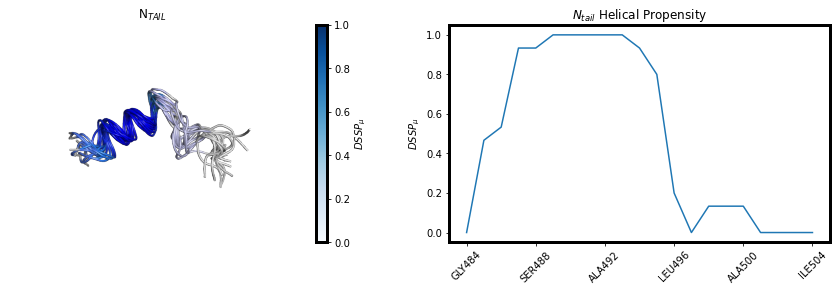

In [5]:
key = "Blues"

start = 110
indices = np.arange(start,start+15)
beta_values = np.where(md.compute_dssp(trj)=="H",1,0)[indices].mean(0)

image = visualize.make_structures(trj=trj.center_coordinates(),
                                  indices= indices,
                                  dir=f"{out_dir}/images",
                                  ensemble=True,
                                  name = "test",
                                  overwrite=True,
                                  transparency=.1,
                                  ref=pdb,
                                  beta_values=beta_values,
                                  palette = visualize.palettes[key],
                          
                                  )

fig, axes = plt.subplots(1,2, figsize = (15,4))
ax = axes.flat
visualize.plot_structure(image, title = f"{protein_name}", 
                         cmap = key,
                         vmin=beta_values.min(),
                         vmax=beta_values.max(),
                         cbar_label=r"$DSSP_{\mu}$",
                         ax = ax[0])
ax[1].plot(beta_values)
ax[1].set_xticks(np.arange(0,21,4))
_=ax[1].set_xticklabels(residues[::4], rotation=45)
ax[1].set_ylabel(r"$DSSP_{\mu}$")
ax[1].set_title(r"$N_{tail}$ Helical Propensity")


In [6]:
#get CA coords
xyz = trj.atom_slice(trj.topology.select("name CA")).xyz
#instantiate writhe class
writhe = Writhe(xyz)
#compute writhe at segment length : 2 (uses parallelization over the cpu cores)
writhe_data = writhe.compute_writhe(length = 2,
                                    matrix = True,
                                    store_results = True,
                                    return_segments=False,
                                    adj_matrix=False)

2023-09-19 12:00:31,076	INFO worker.py:1636 -- Started a local Ray instance.


 # Test Speed The Parallelized Computation

In [5]:
#test the speed of the calculation without storing and reshaping data
writhe.compute_writhe(length=2, speed_test=True)
print(f"Frame Count : {trj.n_frames}")

2023-09-13 22:42:43,150	INFO worker.py:1636 -- Started a local Ray instance.


Time elapsed : 7.600480318069458 s
Frame Count : 119921


# Use Writhe Class Plotting Functions to visualize the results.
# The make_structures and plot_structure functions generate pymol respresentations of the structures corresponding to the writhe data on the fly.

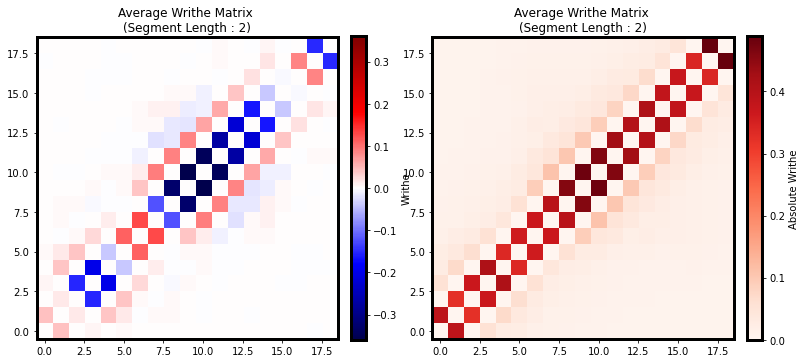

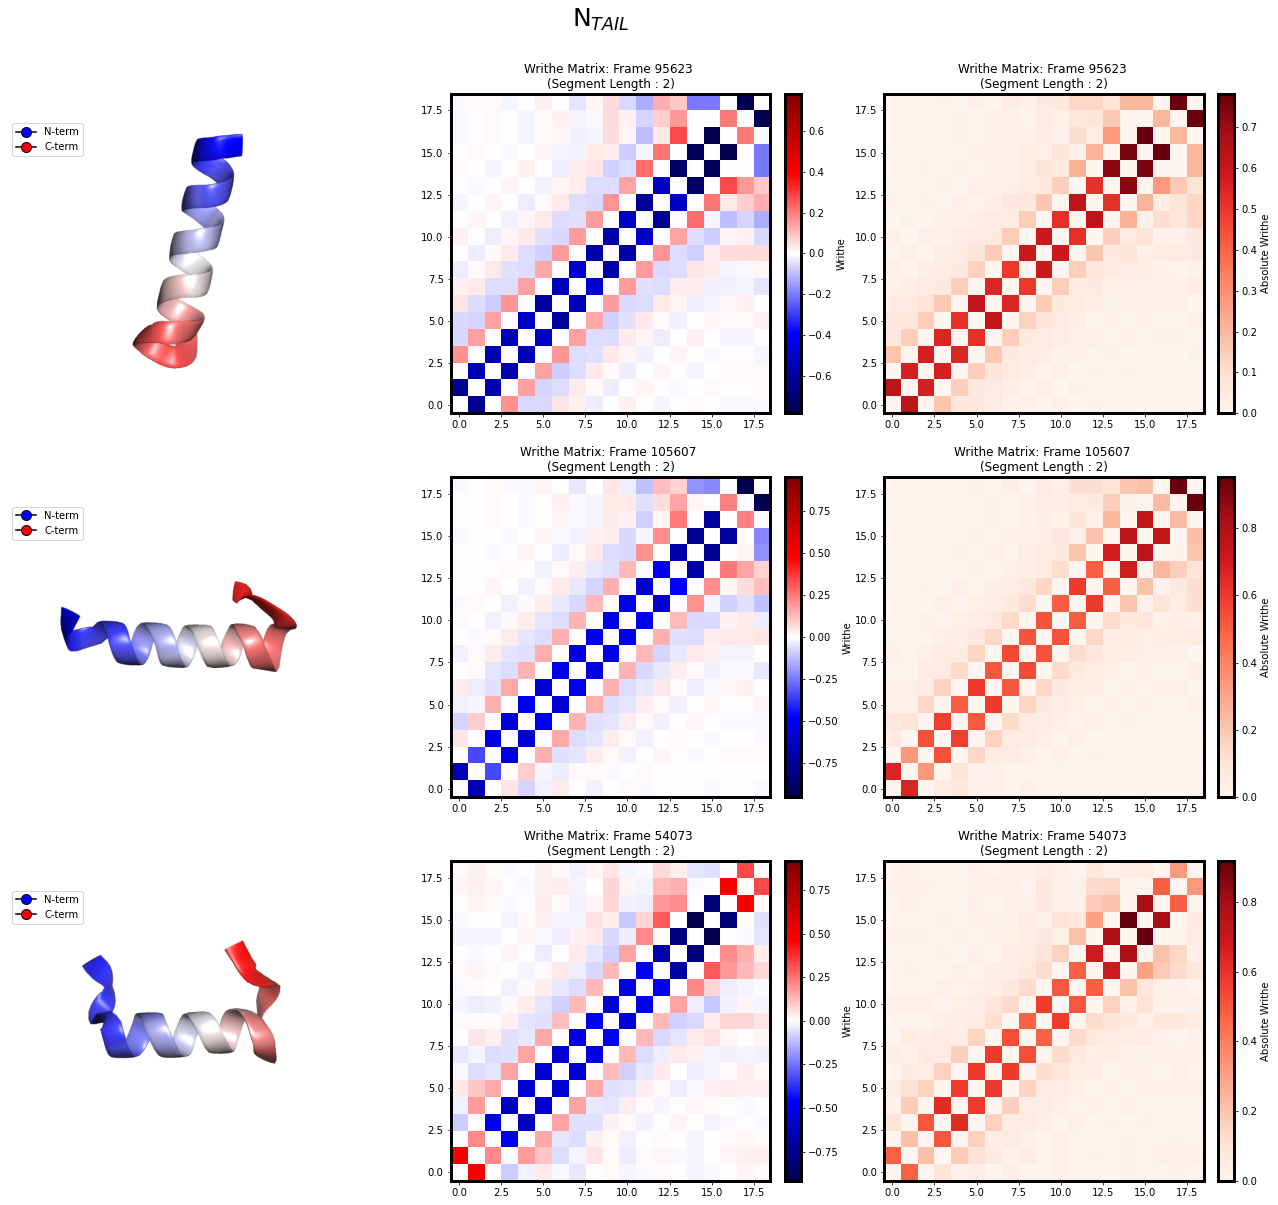

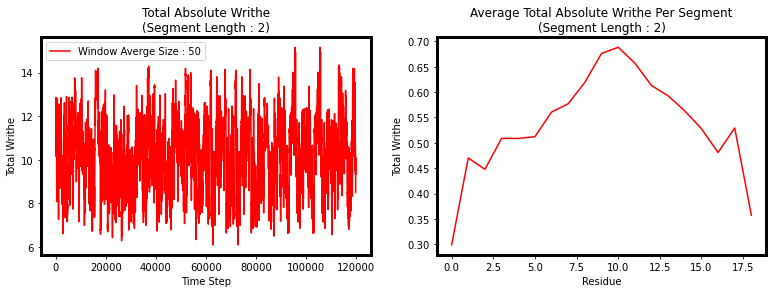

In [7]:
fig, axes = plt.subplots(1,2,figsize=(13,13))
ax=axes.flat
#plot the average 
writhe.plot_writhe_matrix(ax=ax[0])
#plot the absolute value average
writhe.plot_writhe_matrix(absolute=True,ax=ax[1])

#plot the writhe matrix at different timesteps
fig,axes=plt.subplots(3,3, figsize=(22,20))

idx=abs(writhe_data["writhe_features"]).sum(1).argsort()[::-1].astype(int)

#asyn apo c-term indices : idx[0], 168477, 34708
#indices = [idx[0], 168477, 34708]

# ACTR indices idx[[4,20]].tolist()+[idx[-15000]]
indices = idx[:3]

fig.suptitle(protein_name, fontsize=25, y=.94)
for ax, index in zip(axes, [idx[0],idx[12],idx[20]]):
    structure=visualize.make_structures(trj=trj, indices=int(index), dir=f"{out_dir}/images")
    visualize.plot_structure(image=structure, ax=ax[0])
    writhe.plot_writhe_matrix(index=index, ax=ax[1])
    writhe.plot_writhe_matrix(index=index, ax=ax[2], absolute=True)
    
    
#plot the total absolute writhe in a time series with a windowed average
fig, axes = plt.subplots(1,2,figsize=(13,4))
ax=axes.flat
writhe.plot_writhe_total(window=50,ax=ax[0])
#plot the average absolute writhe per segment
writhe.plot_writhe_per_segment(ax=ax[1])


# Use Same Instance To Compute and Plot Writhe Data At Different Segment Lengths

2023-09-19 12:01:26,679	INFO worker.py:1636 -- Started a local Ray instance.
2023-09-19 12:01:35,748	INFO worker.py:1636 -- Started a local Ray instance.
2023-09-19 12:01:43,472	INFO worker.py:1636 -- Started a local Ray instance.
2023-09-19 12:01:51,268	INFO worker.py:1636 -- Started a local Ray instance.
2023-09-19 12:01:59,138	INFO worker.py:1636 -- Started a local Ray instance.
2023-09-19 12:02:06,942	INFO worker.py:1636 -- Started a local Ray instance.


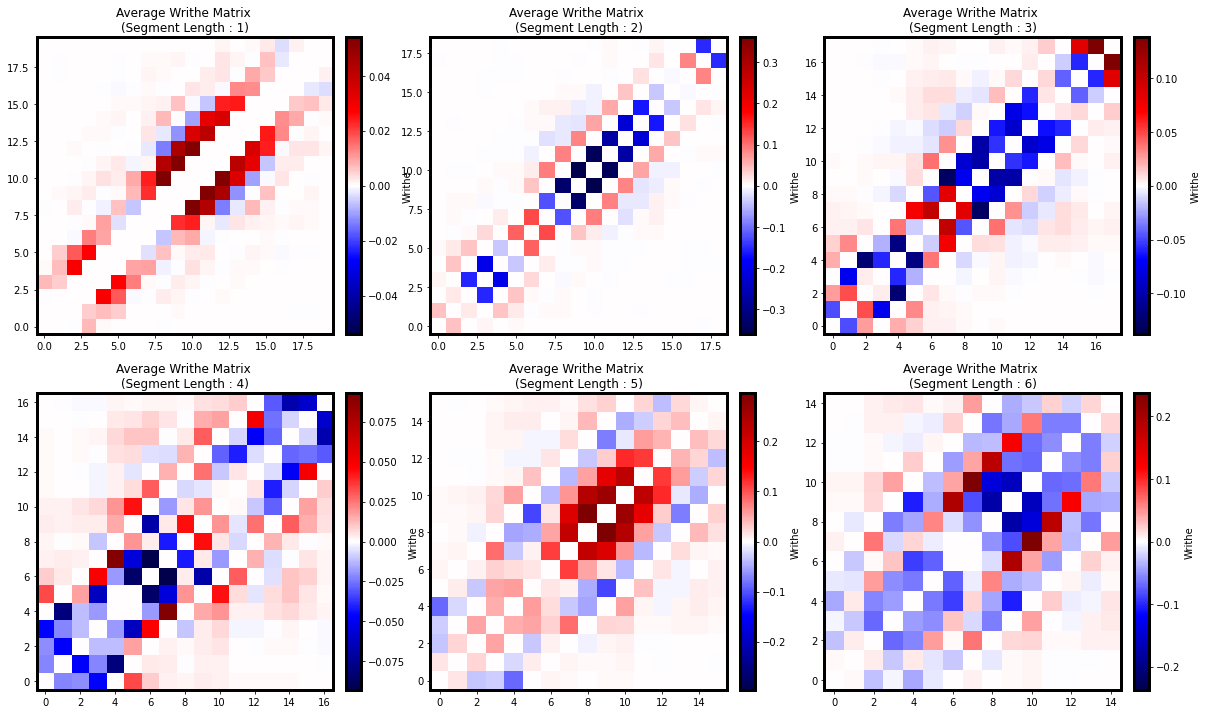

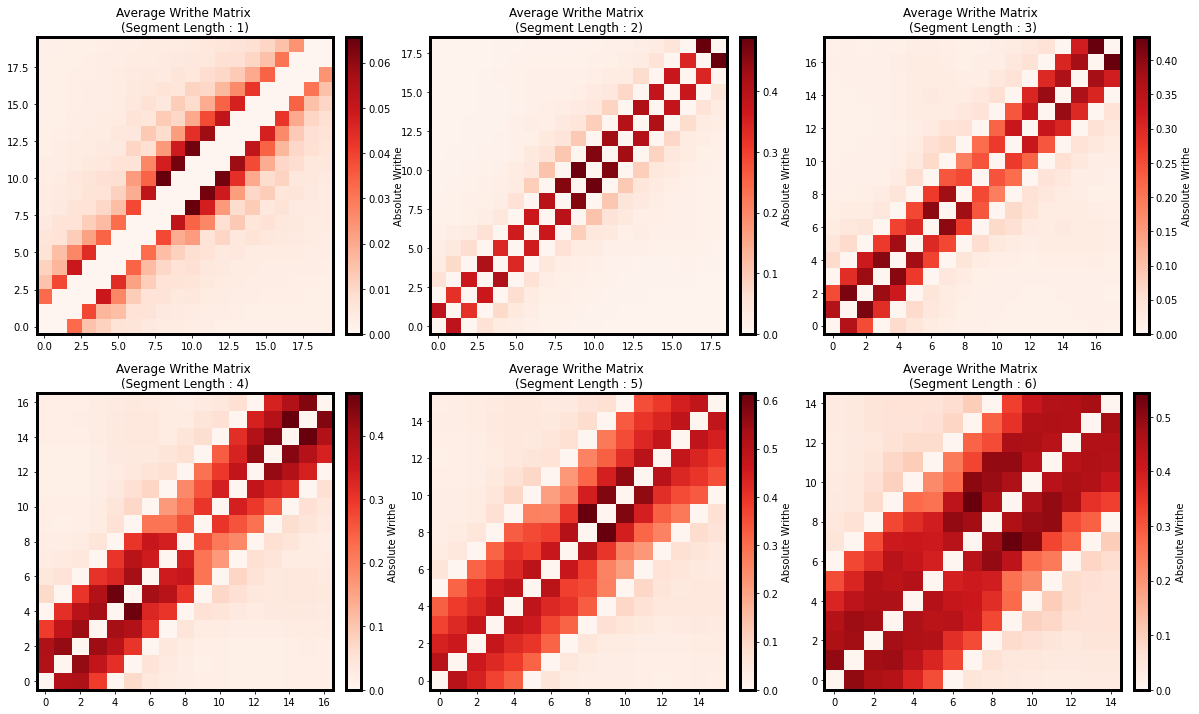

In [8]:
#compute and plot the writhe for different segment lengths
lengths=[1,2,3,4,5,6]
writhe_datasets={}
fig, axes = plt.subplots(2,3, figsize=(20,12))
fig_abs, axes_abs = plt.subplots(2,3, figsize=(20,12))
for ax, ax_abs,length in zip(axes.flat, axes_abs.flat, lengths):
    writhe_data_ = writhe.compute_writhe(length = length,
                                         matrix = True,
                                         store_results = True,
                                        )
    writhe_datasets[length] = {"data":writhe_data_["writhe_features"]}
    writhe.plot_writhe_matrix(ax=ax)
    writhe.plot_writhe_matrix(ax=ax_abs,absolute=True)




# Compute the VAMP scores of writhe, intramolecular distance datasets datasets and compare 

In [9]:
from numpy.linalg import inv, eig, eigh, svd

def halfinv(x, epsilon:float=1e-7):
    l,v=eigh(x)
    if epsilon is not None:
        idx = l>epsilon
        l = l[idx]
        v = v[...,idx] 
    return v@np.diag(1/np.sqrt(l))@v.T

def center(x):
    return x-x.mean(0)

def cov(x,y=None):
    if y is None:
        y=x
    return center(x).T@center(y)*(1/(len(x)-1))

def svals(x):
    """compute just the **squared** singular values (or eigen values) from svd.
    If the matrix is symmetric, these will be the singular values"""
    return np.sort(eig(x.T@x)[0])[::-1]

def pca(x:np.ndarray, dim:int=-1):
    "compute the business half of econ svd"
    l,v=eig(cov(x))
    idx=l.argsort()[::-1]
    v=v[...,idx]
    l=l[idx]
    l, v = l[:dim],v[...,:dim]
    projection = center(x)@v
    return projection, l, v

CCA_matrix=lambda x0,xt : halfinv(cov(x0)) @ cov(x0,xt) @ halfinv(cov(xt))
tCCA_matrix=lambda x,lag : CCA_matrix(x[:-lag],x[lag:])

def vamp2(x, lag:int, dim:int=5, sum_=True):
    
    singular_values = svals(tCCA_matrix(x, lag))[:dim]
    
    #for stochastic matrix, +1 for constant fxn
    #(lost deg of freedom from subtracting the mean (whitening))
    
    if sum_:
        return singular_values.sum()
    
    else:
        return singular_values
    

# class setup for CCA and tCCA to avoid repeated computations   

class CCA:
    
    def __init__(self, x0:np.ndarray, x1:np.ndarray, epsilon:int=1e-7):
        
        self.x0 = x0
        self.x1 = x1
        self.epsilon = epsilon
    
    def fit(self, x0:np.ndarray=None, x1:np.ndarray=None):
        
        if x0 is None:
            x0 = self.x0
        
        if x1 is None:
            x1 = self.x1
        
        
        pseudo_half_inv = {attr:halfinv(cov(x), self.epsilon)
                           for attr,x in zip("x0,x1".split(","), [x0,x1])}
        
        
        cca = pseudo_half_inv["x0"] @ cov(x0,x1) @ pseudo_half_inv["x1"]
        
        v0, s, v1_t = np.linalg.svd(cca)
        
        v1 = v1_t.T
        
        for key in "pseudo_half_inv,cca,v0,s,v1".split(","):
            setattr(self, key, locals()[key])
        
        return self
    
    def transform(self, dim:int=2, x:str=None):
        
        if x is None:
            
            return [center(getattr(self,x))@self.pseudo_half_inv[x]@getattr(self,"v"+x[-1])
                    for x in "x0,x1".split(",")]
        
        else:
            assert x in "x0,x1".split(","), "x input should be str x0 or x1"
            
            return center(getattr(self,x))@self.pseudo_half_inv[x]@getattr(self,"v"+x[-1])
    
    def fit_transform(self, x0:np.ndarray=None, x1:np.ndarray=None,
                      x:str=None, dim:int=2):
        
        
        self.fit(x0=x0, x1=x1)
        
        return self.transform(x=x, dim=dim)

    
class tCCA(CCA):
    def __init__(self, data, lag, epsilon=1e-7):
        super().__init__(x0=data[:-lag], x1=data[lag:], epsilon=epsilon)
        self.lag = lag
        self.data = data
        
    


In [10]:
#compute distances
distances=md.compute_contacts(trj,np.stack(np.triu_indices(len(residues),1)).T)[0]
distance_datasets = {l:{} for l in lengths}

#compute the scores at increasing lagtimes
lags=list(range(1,102,10))
eigen_values=[]
for length, dic in writhe_datasets.items():
    
    #remove distances from residue pairs "length" or less apart in sequence
    #avoid holding the intermediate distance datasets in memory
    
    distance_data=distances[:,utils.triu_flat_indices(len(residues),1,length)]
    
    #fill dictionaries with scores
    writhe_datasets[length]["scores"] = np.stack([vamp2(dic["data"], lag, 5, False)
                                                  for lag in lags])
    
    distance_datasets[length]["scores"] = np.stack([vamp2(distance_data, lag, 5, False)
                                                    for lag in lags])

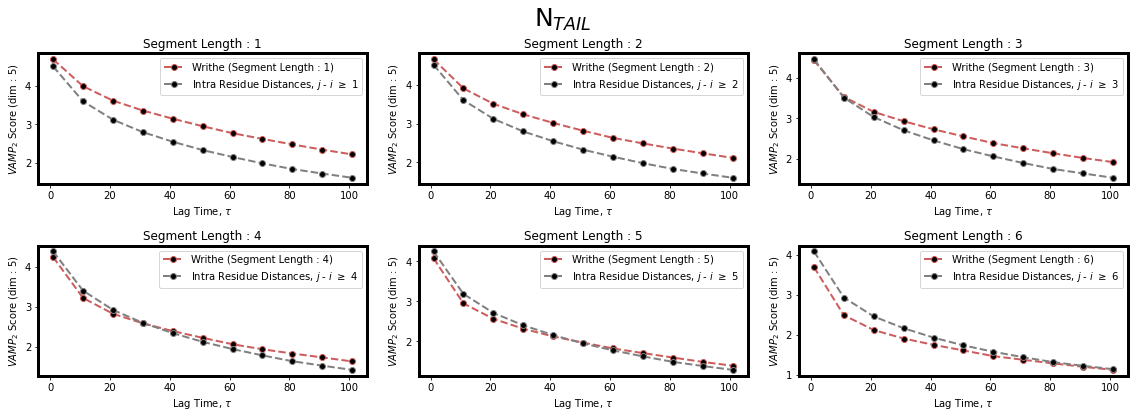

In [11]:
from matplotlib.lines import Line2D
fig,axes=plt.subplots(2,3,figsize=(16,6))

for ax,length in zip(axes.flat, lengths):
    
    ax.plot(lags,writhe_datasets[length]["scores"].sum(-1),
             label=f"Writhe (Segment Length : {length})",
             color="indianred",
             lw=2,
             ls="--",
             marker="o",
             mfc="black")
    
    
    ax.plot(lags,distance_datasets[length]["scores"].sum(-1),
             label=f"Intra Residue Distances, $j$ - $i$ $\geq$ {length}",
             color="gray",
             lw=2,
             ls="--",
             marker="o",
             mfc="black")
    

    ax.set_ylabel("$VAMP_{2}$ Score (dim : 5)")
    ax.set_xlabel(r"Lag Time, $\tau$")
    ax.set_title(f"Segment Length : {length}")
    ax.legend()
    
fig.suptitle(protein_name, fontsize=25, y=.96)
plt.tight_layout()

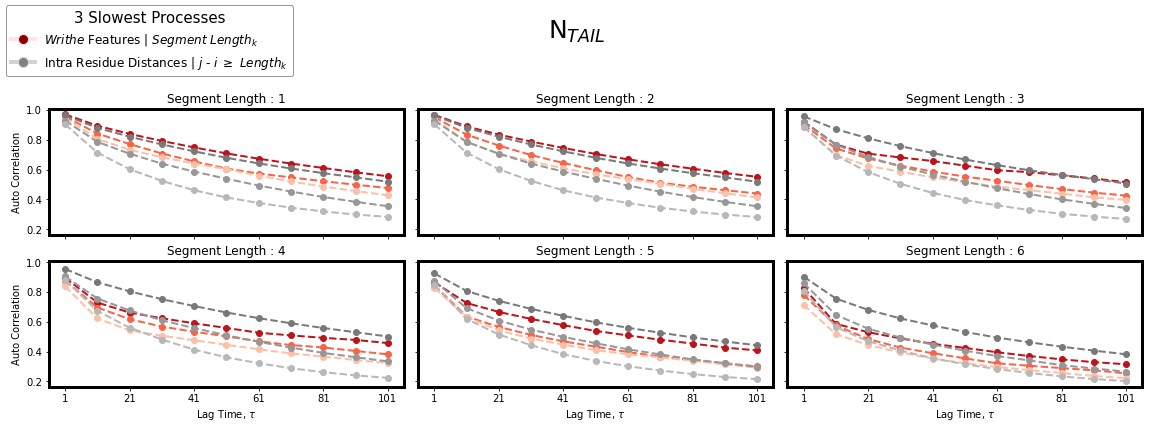

In [12]:
from cycler import cycler
n_procs=3
fig,axes=plt.subplots(2,3,figsize=(16,6),sharey=True, sharex=True)

for ax,length in zip(axes.flat, lengths):
    
    ax.set_prop_cycle((cycler(color=visualize.get_color_list(n_procs,"Reds_r",trunc=60,pre_trunc=50)
                             )))
    
    ax.plot(writhe_datasets[length]["scores"][:,:n_procs],
             label=f"Writhe (Segment Length : {length})",
             lw=2,
             ls="--",
             marker="o")
    
    
    ax.set_prop_cycle((cycler(color=visualize.get_color_list(n_procs,"Greys_r",trunc=100, pre_trunc=100)
                             )))
    
    ax.plot(distance_datasets[length]["scores"][:,:n_procs],
             label=f"Writhe Features (Segment Length : {length})",
             lw=2,
             ls="--",
             marker="o")
    
    ax.set_xticks(range(0,len(lags),2),lags[::2])

    ax.set_title(f"Segment Length : {length}")


for ax in axes[:,0]:
    ax.set_ylabel("Auto Correlation")
for ax in axes[-1]:
    ax.set_xlabel(r"Lag Time, $\tau$")
    

fig.suptitle(protein_name, fontsize=25, y=.96)

legend_elements = [Line2D([0], [0], marker="o", color='mistyrose',
                          label="$Writhe$ Features | $Segment$ $Length_{k}$",
                          markerfacecolor="darkred", markersize=10, lw=4),
                   Line2D([0], [0], marker="o", color='lightgray',
                          label='Intra Residue Distances | $j$ - $i$ $\geq$ $Length_{k}$',
                          markerfacecolor="gray", markersize=10,lw=4)]

fig.legend(handles=legend_elements,title=f"{n_procs} Slowest Processes",loc="upper left",
          fontsize=12, title_fontsize=15, edgecolor=(.5,.5,.5))

plt.tight_layout()
plt.subplots_adjust(top=.75)

 # What Segment length(s) should be used?
 
 
 
 
 
    We can plot the VAMP score as a function of the writhe segment length to determine     the optimal segment length(s) for identifying slow dynamical modes/conformational       transitions from our trajectory data.
 


Text(0.5, 1.0, 'N$_{TAIL}$')

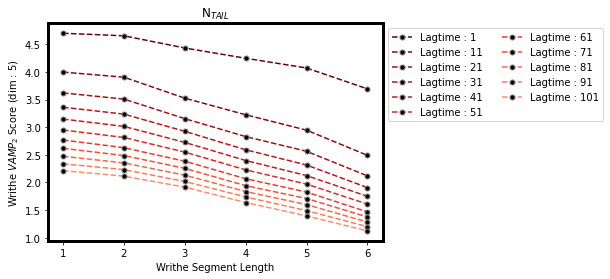

In [13]:
scores=np.stack([dic["scores"].sum(-1) for dic in writhe_datasets.values()])

for score,label,color in zip(scores.T,
                             [f"Lagtime : {lag}" for lag in range(1,102,10)],
                             visualize.get_color_list(len(lags),"Reds_r",trunc=100)):
    
    plt.plot(lengths,
             score,
             color=color,
             label=label,
             ls="--",
             marker="o",
             ms=5,
             mfc="black",
             mec="gray")
    
    
plt.xticks(range(1,lengths[-1]+1))
plt.ylabel("Writhe $VAMP_{2}$ Score (dim : 5)")
plt.xlabel(r"Writhe Segment Length")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left',ncol=2)
plt.title(protein_name)


# From the vamp score, we see that writhe datasets computed with segment lengths of 1 and 2 are best.

    When combining writhe datasets computed using different segment lengths as a means for finding an optimal input for dimensionality reduction or deep learning models, the relaxation timescales (vamp score computed at varying lagtimes) should be similar at the lagtime of the model. This is because these models generally aim to maximize the autocorrelation of the transformed data at a target lagtime.

    Given that writhe computed at different length scales probe different geometric features of a protein's topology, combining these datasets should provide a good description of the system and it's slow dynamics).

# Here, we'll combine the writhe data sets computed at a variety of segment lengths



In [14]:
from functools import partial

combined_feature_lengths = [[1,2], [2,3], [1,2,3], [1,2,3,4]][::-1]
proj_lag = 5
proj_dim = 2

#make the combined "feature" sets
writhe_feature_sets = {}
for combine_lens in combined_feature_lengths:
    dic = {}
    data = np.concatenate([writhe_datasets[length]["data"] for length in combine_lens],axis=-1)
    dic["scores"] = np.stack([vamp2(x=data, lag=lag, sum_=False) for lag in lags])
    dic["proj"] = tCCA(data=data,lag=proj_lag).fit_transform(x="x0", dim=proj_dim)
    writhe_feature_sets["".join(list(map(str,combine_lens)))] = dic
    

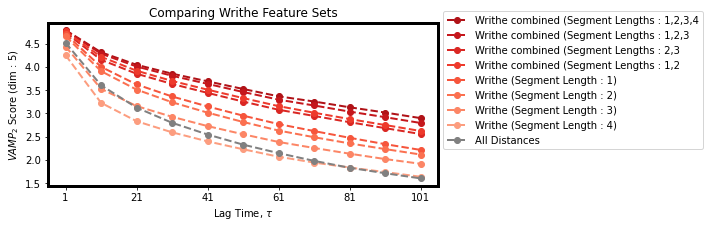

In [15]:
fig, ax = plt.subplots(1,figsize=(7,3),sharey=True, sharex=True)

ax.set_prop_cycle((cycler(color=visualize.get_color_list(10,"Reds_r",trunc=50, pre_trunc=40)
                         )))


for key, val in writhe_feature_sets.items():
    
    ax.plot(val["scores"].sum(-1),
            label=f"Writhe combined (Segment Lengths : {','.join(list(iter(key)))}",
            lw=2,
            ls="--",
            marker="o")


#plot vamp scores for writhe calculated at segment lengths used in combined feature sets
for length in set([item for sublist in combined_feature_lengths for item in sublist]):
    ax.plot(writhe_datasets[length]["scores"].sum(-1),
             label=f"Writhe (Segment Length : {length})",
             lw=2,
             ls="--",
             marker="o")


ax.plot(distance_datasets[1]["scores"].sum(-1),
         label="All Distances",
         lw=2,
         ls="--",
         marker="o", 
         color = "gray")


ax.set_ylabel("$VAMP_{2}$ Score (dim : 5)")
ax.set_xlabel(r"Lag Time, $\tau$")
ax.set_xticks(range(0,len(lags),2),lags[::2])
ax.set_title("Comparing Writhe Feature Sets")
ax.legend(bbox_to_anchor= (1,1.1), loc="upper left")

/home/t/writhe/visualize.py:241: RuntimeWarning: divide by zero encountered in log
  F = -np.log(arr)


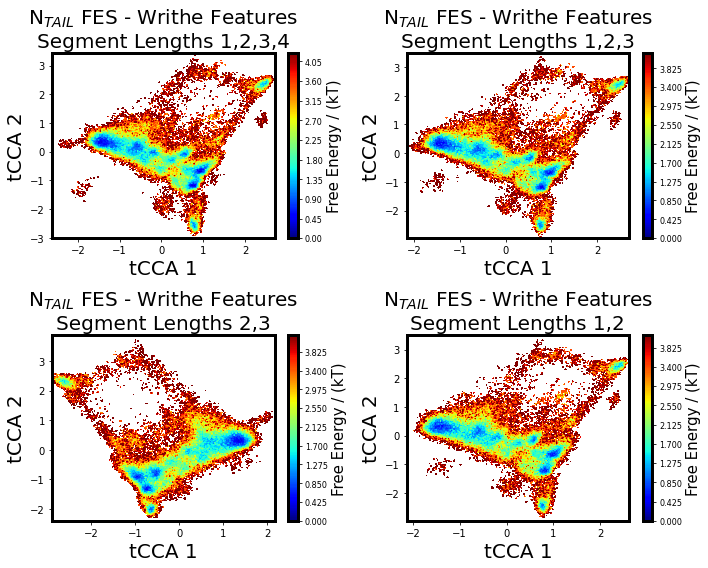

In [16]:
fig, axes = plt.subplots(2,2,figsize=(10,8))

for ax, (key, value) in zip(axes.flat, writhe_feature_sets.items()):
    visualize.fes2d(
                    value["proj"],
                    title = (f"{protein_name} FES - Writhe Features\n"
                    f"Segment Lengths {','.join(list(iter(key)))}"),
                    x_label="tCCA 1", y_label="tCCA 2",
                    ax=ax,
                    bins=250)
    
plt.tight_layout()

 # Let's project the writhe and distance data onto the dominant singular functions of their Koopman matrices

In [17]:
feat_idx = "1234"
distance_projection = tCCA(
   distances[:,utils.triu_flat_indices(len(residues),1,2)], proj_lag).fit_transform(x="x0",dim=proj_lag)

Text(0.48, 1, 'N$_{TAIL}$')

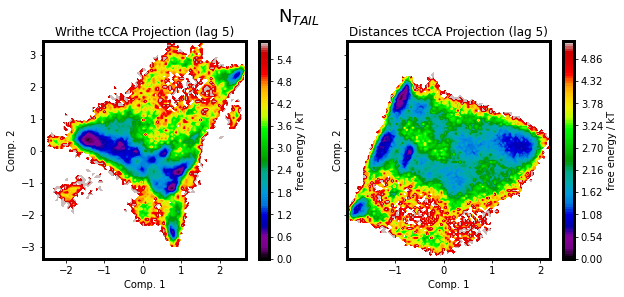

In [18]:
import pyemma
fig,axes=plt.subplots(1,2, sharey=True,figsize=(10,4))
for ax,name,data in zip(axes.flat, 
                        "Writhe,Distances".split(","),
                        [writhe_feature_sets[feat_idx]["proj"],
                        distance_projection]
                       ):
    
    ax.set_xlabel("Comp. 1")
    ax.set_ylabel("Comp. 2")
    ax.set_title(f"{name} tCCA Projection (lag {proj_lag})")
    pyemma.plots.plot_free_energy(*data[:,:2].T,ax=ax )
fig.suptitle(protein_name, fontsize=18, y=1,x=.48)

 # Clustering

In [19]:
from functools import partial

def sort_by_val_in(indices, value, order:"-1:max or 1:min"=-1):
    return indices[np.argsort(value[indices])[::order]]

def sort_idx_list_obs(indices_list,
                obs,
                stat:callable=np.mean,
                max=True,
                ret_stat=False,
                sort_indices=False,
               ):
    if max:
        stride = -1
    else:
        stride = 1
    
    apply_stat=lambda s=stat,o=obs,l=indices_list:np.array([s(o[i]) for i in l])
    
    returns = {}
    
    if sort_indices:
        returns["indices_list"] = list(map(
            partial(sort_by_val_in, value=obs, order=stride),
            indices_list))
        
    if ret_stat:
        
        values = apply_stat()
        returns["index"] = values.argsort()[::stride]
        returns["values"]=values

        return returns
     
    else:
        returns["index"] = np.argsort(apply_stat())[::stride]
        return returns
        
#list(map(indices_list.__getitem__, idx))

In [20]:
sa = SA(trj, md.load("./Ntail.helix.pdb"))

In [36]:
from sklearn.cluster import KMeans
from itertools import repeat
n_clusters = 30

def closest_points(point:np.ndarray, points:np.ndarray, axis=-1):
    return np.argsort(np.linalg.norm(points-points, axis=axis))

def Kmeans(p, n_clusters, n_dim):
    
    #ensure data is correct shape, num dims
    p = np.copy(p[...,:n_dim])
    
    #use kmeans class from sklearn
    kmeans = KMeans(n_clusters=n_clusters)
    dtraj = kmeans.fit_predict(p)
    km_distances = kmeans.transform(p).min(1)
    
    #find frames for each cluster
    frames_cl = [np.where(dtraj==i)[0] for i in range(n_clusters)]
    
    #return dtraj and frames for each cluster sorted by distance from centers
    
    return dtraj, [sort_by_val_in(frames, km_distances, order=1) for frames in frames_cl]



dtraj, frames_cl = Kmeans(writhe_feature_sets[feat_idx]["proj"], n_clusters, proj_dim)


pop_idx, counts = sort_idx_list_obs(indices_list=frames_cl,
                                    obs=np.ones(trj.n_frames),
                                    stat=len,
                                    ret_stat=True).values()

populations=np.round(100*counts/trj.n_frames,2)


sa_frames_cl, sa_cl_idx, sa_cl_mean = sort_idx_list_obs(indices_list=frames_cl,
                                                        obs=sa.sum(1),
                                                        sort_indices=True,
                                                        ret_stat=True).values()

/home/t/writhe/visualize.py:241: RuntimeWarning: divide by zero encountered in log
  F = -np.log(arr)


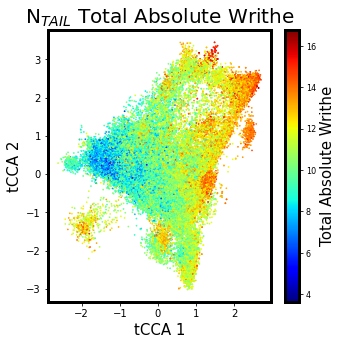

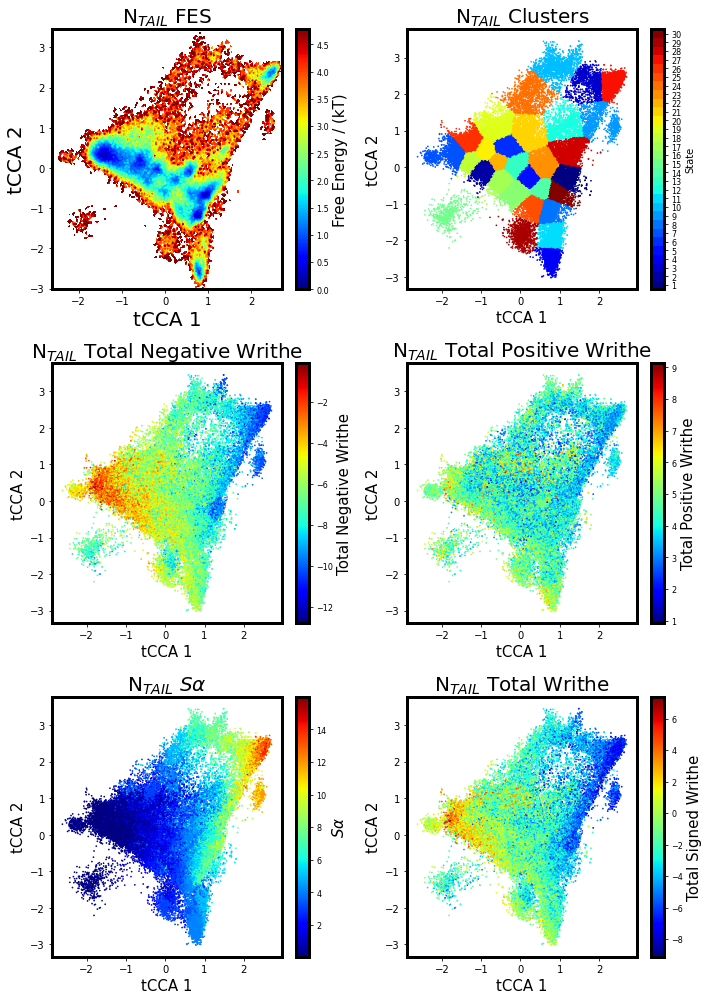

In [37]:
# set the length to use for projections
len_idx=2

#plot the total absolute writhe
visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 abs(writhe_datasets[len_idx]["data"]).sum(1)[:-proj_lag],
                 title = f"{protein_name} Total Absolute Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Absolute Writhe",)


#subplot for state map, FES, variations of writhe
fig, axes = plt.subplots(3,2,figsize=(10,14))
ax=axes.flat

visualize.fes2d(writhe_feature_sets[feat_idx]["proj"],
     title = f"{protein_name} FES",
     x_label="tCCA 1", y_label="tCCA 2",
     ax=ax[0])


visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 dtraj, state_map=True,
                 title = f"{protein_name} Clusters",
                 x_label="tCCA 1", y_label="tCCA 2",
                 ax=ax[1])


visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 np.where(writhe_datasets[len_idx]["data"]<=0,
                          writhe_datasets[len_idx]["data"],0).sum(1)[:-proj_lag],
                 title = f"{protein_name} Total Negative Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Negative Writhe",
                 ax=ax[2])


visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 np.where(writhe_datasets[len_idx]["data"]>=0,
                          writhe_datasets[len_idx]["data"],0).sum(1)[:-proj_lag],
                 title = f"{protein_name} Total Positive Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Positive Writhe",
                 ax=ax[3])



visualize.proj2d(writhe_feature_sets[feat_idx]["proj"], sa.sum(1)[:-proj_lag],
                 title = rf"{protein_name} $S\alpha$",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label=r"$S\alpha$",
                 ax=ax[4])

visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 writhe_datasets[len_idx]["data"].sum(1)[:-proj_lag],
                 title = f"{protein_name} Total Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Signed Writhe",
                 ax=ax[5])
plt.tight_layout()

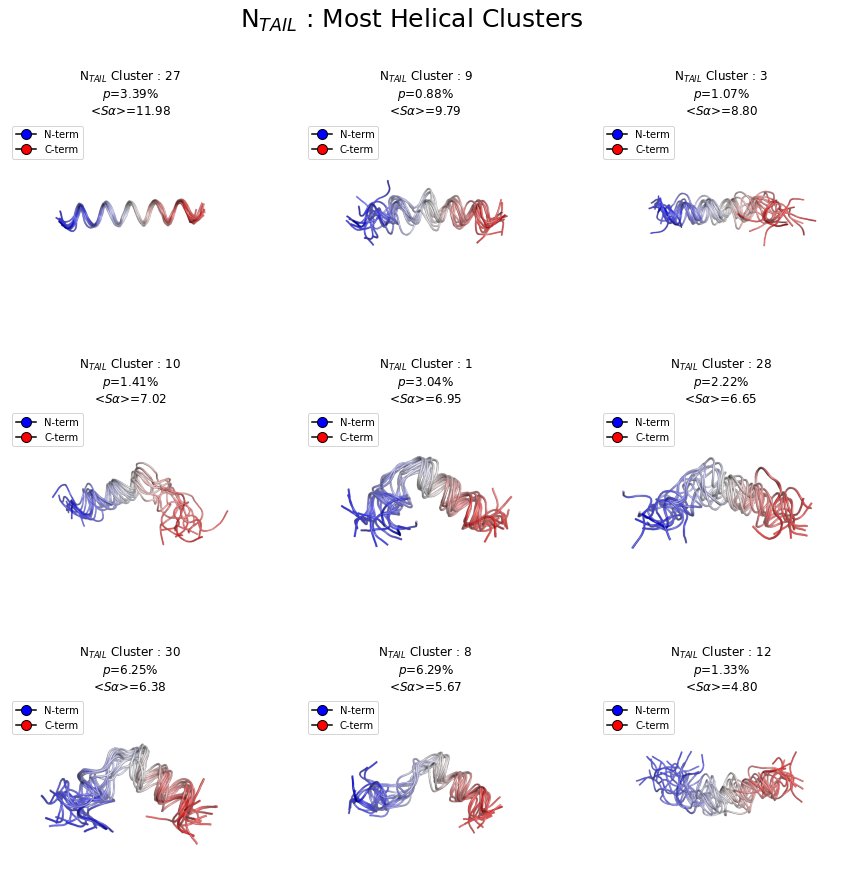

In [38]:
n_closest = 15
palette = "blue_gray90_red"
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]

fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Helical Clusters", fontsize=25, y=.96)
for i,salpha, pop, ax, indices in zip(sa_cl_idx,
                                      sa_cl_mean[sa_cl_idx],
                                      populations[sa_cl_idx],
                                      axes.flat, 
                                      list(map(sa_frames_cl.__getitem__, sa_cl_idx)),
                               ):

    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=palette,
                                      ref=pdb)

    visualize.plot_structure(image,
                             nterm_color=nterm_color,
                             cterm_color =cterm_color,
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"
                                      "\n"
                                      rf"<$S\alpha$>={salpha:.2f}"),
                             ax=ax)
    


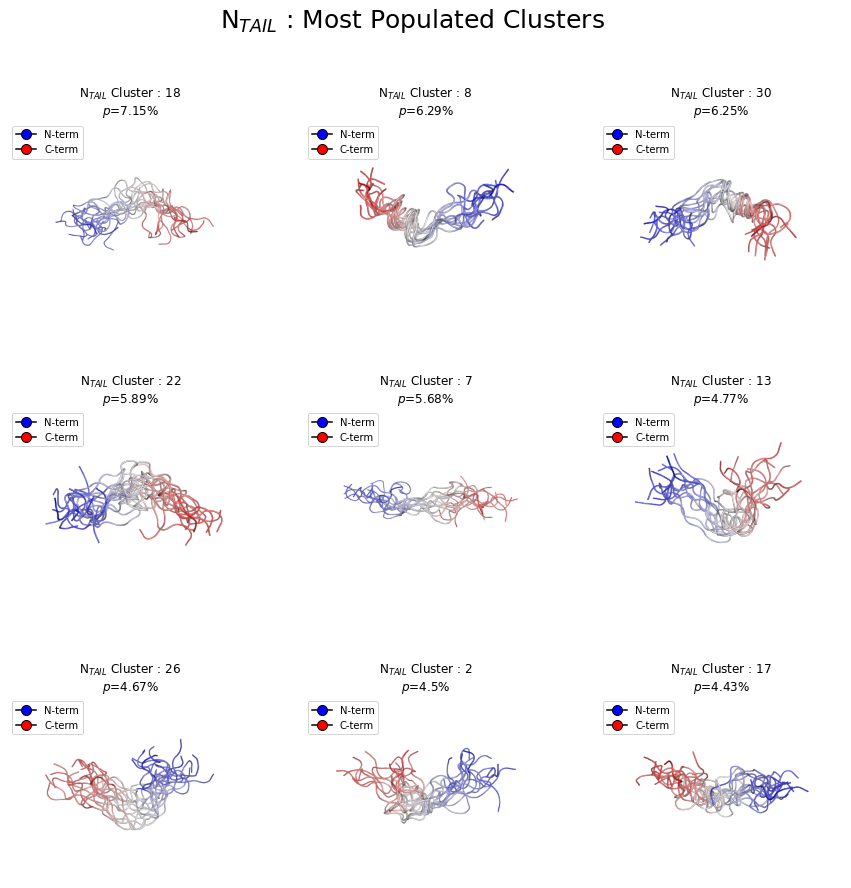

In [39]:
n_closest = 15
palette = "blue_gray90_red"
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]

fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Populated Clusters", fontsize=25, y=.96)
for i, pop, ax, indices in zip(pop_idx,
                               populations[pop_idx],
                               axes.flat, 
                               list(map(frames_cl.__getitem__, pop_idx)),
                              ):

    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=palette,
                                      ref=pdb)

    visualize.plot_structure(image,
                             nterm_color=nterm_color,
                             cterm_color =cterm_color,
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"),
                             ax=ax)

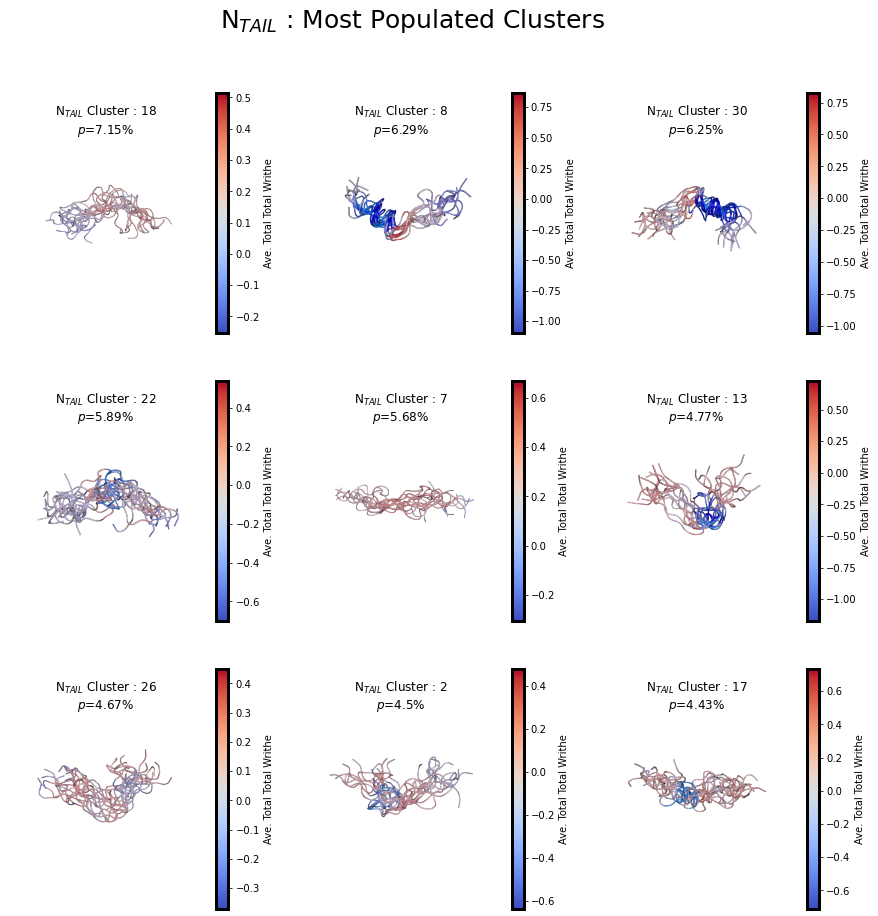

In [40]:
n_closest = 15
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]
key = "coolwarm"


fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Populated Clusters", fontsize=25, y=.96)
for i, pop, ax, indices in zip(pop_idx,
                               populations[pop_idx],
                               axes.flat, 
                               list(map(frames_cl.__getitem__, pop_idx)),
                              ):

    beta_values = to_writhe_adj_matrix(
        writhe_datasets[len_idx]["data"][indices[:n_closest]], 21, len_idx).mean(0).sum(0)
    
    
    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=visualize.palettes[key],
                                      ref=pdb,
                                      beta_values=beta_values,
                                      beta_min = -1,
                                      beta_max = 1)

    visualize.plot_structure(image,
                             cmap=key,
                             vmin=beta_values.min(),
                             vmax=beta_values.max(),
                             cbar_label = "Ave. Total Total Writhe",
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"),
                             ax=ax)

In [48]:
import deeptime

def sorted_eig(x, sym=False, real=True, return_check=False):
    if sym:
        lam, v = np.linalg.eigh(x)
    else:
        lam, v = np.linalg.eig(x)

    check_real = {}
    for i, name in zip([lam, v], "eigen_vals,eigen_vecs".split(",")):
        check = np.iscomplex(i).any()
        check_real[name] = check

    if real:
        lam, v = [i.real for i in [lam, v]]

    idx = abs(lam).argsort()[::-1]
    lam = lam[idx]
    v = v[:, idx]
    if return_check:
        return lam, v, check_real
    else:
        return lam, v
    
    
def reindex_dtraj(dtraj, obs, maximize_obs=True):
    """given a discrete trajectory and an observable, we reindex the trajectory 
    based on the mean of the observable in each state (high to low)
    maximize_obs has been added to increase flexibility as one might want to reindex
    states in order of smallest mean value of observable"""
    nstates = dtraj.max() + 1  # number of states
    # get the sorted cluster indices based on mean of observable
    if maximize_obs:
        idx = np.array([obs[np.where(dtraj == i)[0]].mean()
                        for i in range(nstates)]).argsort()[::-1]
    else:
        idx = np.array([obs[np.where(dtraj == i)[0]].mean()
                        for i in range(nstates)]).argsort()
    # make a  mapping of old indices to new indices
    mapping = np.zeros(nstates)
    mapping[idx] = np.arange(nstates)
    # map the states
    new_dtraj = mapping[dtraj]
    return new_dtraj, idx

def reindex_matrix(mat: np.ndarray, reindex: np.ndarray):
    """reindex matrix based on indices in idx"""
    if len(mat.shape) == 2:
        mat = mat[reindex, :]
        mat = mat[:, reindex]
    if len(mat.shape) == 3:
        mat = mat[:, reindex, :]
        mat = mat[:, :, reindex]
    return mat


    
def get_its(mats, tau: int):
    n = len(mats)
    est_lams = np.stack([sorted_eig(mat)[0] for mat in mats], axis=1)[1:]
    if (est_lams < 0).any():
        est_lams = abs(est_lams)
    predict = np.stack([-(tau * i) / np.log(est_lams[:, 0] ** i) for i in range(1, n + 1)], axis=1)
    estimate = np.stack([-(tau * i) / np.log(est_lams[:, i - 1]) for i in range(1, n + 1)], axis=1)
    return predict, estimate

def plot_its(estimate: np.ndarray, estimate_error=None, lag: int = 1, dt: float = .2, unit="ns",
             cmap:str="jet", fig_width=10, fig_length=6, title: str = "Implied Timescales",
             ax = None, plot_text_scale:float=5):
    
    """estimate: eigen vals estimated at integrer multiples of the lag time
    predict: eigen vals of the initial lagtime propogated via exponentiation"""
    
    nprocs, nsteps = estimate.shape
    cmap = getattr(plt.cm, cmap)
    cs = [cmap(i) for i in range(cmap.N)]
    color_list = [cs[int(i)] for i in np.linspace(10, len(cs) - 20, nprocs)]
    color_list = color_list[::-1]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_length))
    
    lag_dt = np.arange(1, nsteps + 1) * lag * dt
    # each iteration plots a single process at all lag times
    for est_proc, color in zip([estimate[i] for i in range(estimate.shape[0])], color_list):
        ax.plot(lag_dt, est_proc, label="Estimate", color=color)
        ax.scatter(lag_dt, est_proc, color=color)
    if estimate_error is not None:
        for est_error, color in zip([estimate_error[:, i] for i in range(estimate_error.shape[1])],color_list):
            ax.fill_between(lag_dt,
                            est_error[0],
                            est_error[1], 
                            label="Estimate",
                            color=color,
                            alpha=.2)

    ax.plot(lag_dt, lag_dt, color="black")
    ax.fill_between(lag_dt, lag_dt, color="gray", alpha=.5)
    ax.set_yscale("log")
    ax.set_ylabel(f"ITS ({unit})", size=5*plot_text_scale)
    ax.set_xlabel(rf"Lag time, $\tau$ ({unit})", size=5*plot_text_scale)
    ax.tick_params(axis="both", labelsize=5*plot_text_scale)
    ax.set_title(label=title, size=6*plot_text_scale)
    
    return None

def plot_cktest(predict: np.ndarray, estimate: np.ndarray,
                lag: int, dt: float, unit="ns",
                predict_color="red", estimate_color="black",
                predict_errors=None, estimate_errors=None,
                fill_estimate=True):
    """predict+errors should be of shape [2,predict/estimate.shape] where the 0th dim is upper and lower
    confidence intervals"""
    
    check_id = lambda x : np.all(x==np.eye(len(x)))
    
    if not check_id(predict[0]):
        predict = np.concatenate([np.expand_dims(np.eye(predict.shape[1], predict.shape[1]), axis=0),
                                  predict])
        
        if predict_errors is not None:
            if not len(predict_errors)!=len(predict):
                predict_errors = np.concatenate(
                [np.expand_dims(np.stack([np.eye(predict.shape[1])] * 2), axis=1), predict_errors],
                    axis=1)
        
    
    if not check_id(estimate[0]):
        predict = np.concatenate([np.expand_dims(np.eye(predict.shape[1], predict.shape[1]), axis=0),
                          estimate])
        
        if estimate_errors is not None:
            if not len(estimate_errors)!=len(estimate):
                estimate_errors = np.concatenate(
                [np.expand_dims(np.stack([np.zeros((predict.shape[1], predict.shape[1]))] * 2), axis=1),
                 estimate_errors], axis=1)

    nsteps, nstates = predict.shape[:2]
    fig, axes = plt.subplots(nstates, nstates, figsize=(15, 15), sharex=True, sharey=True)
    dt_lag = np.arange(nsteps) * lag * dt
    xaxis_marker = np.linspace(0, 1, nsteps)
    padding_between = 0.2
    padding_top = 0.065

    predict_label = "Predict"
    estimate_label = "Estimate"

    for i in range(nstates):
        for j in range(nstates):
            if not predict_errors is None:
                axes[i, j].fill_between(dt_lag, predict_errors[0][:, i, j], predict_errors[1][:, i, j],
                                        color=predict_color, alpha=0.4)

                predict_label += "      conf. 95%"

            if not estimate_errors is None:

                if fill_estimate:
                    axes[i, j].fill_between(dt_lag[1:], estimate_errors[0][1:, i, j], estimate_errors[1][1:, i, j],
                                            color=estimate_color, alpha=0.4)
                else:
                    axes[i, j].errorbar(x=dt_lag, y=estimate[:, i, j],
                                        yerr=abs(estimate_errors[:, :, i, j]),
                                        color=estimate_color, alpha=1)
                estimate_label += "      conf. 95%"

            axes[i, j].plot(dt_lag, predict[:, i, j], ls="--", color=predict_color, label=predict_label)

            axes[i, j].plot(dt_lag, estimate[:, i, j], color=estimate_color, label=estimate_label)

            axes[i, j].set_ylim(0, 1)
            axes[i, j].text(0.1, 0.55, str(i + 1) + ' ->' + str(j + 1),
                            transform=axes[i, j].transAxes, weight='bold', size=12)
            axes[i, j].set_yticks([0, .5, 1], ["0", "0.5", "1"], size=12)
            axes[i, j].set_xticks(dt_lag[[1, -1]], dt_lag[[1, -1]], )

    for axi in axes.flat:
        axi.set_xlabel(None)
        axi.set_ylabel(None)

    fig.supxlabel(rf"Lag time, $\tau$ ({unit})", x=0.5, y=.07, size=25)
    fig.supylabel("Probability", x=.06, y=.5, size=25)
    handels, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handels, labels, ncol=7, loc="upper center", frameon=False, prop={'size': 25})
    plt.subplots_adjust(top=1.0 - padding_top, wspace=padding_between, hspace=padding_between)




def plot_stat_dist(dist: np.ndarray,
                   dist_err: np.ndarray = None,
                   cmap: str = "viridis",
                   title:str="Stationary Distribution",
                   ax=None,
                   plot_text_scale:float=5):

    # make the stationary distribution and it's error 1D vectors 
    # (assuming abs(upper) and abs(lower) errors have been averaged):

    dist, dist_err = [i.squeeze() if i is not None else None for i in [dist, dist_err]]

    assert len(dist.shape) == 1, "Need a stationary distribution that can be squeezed to one dimension"

    nstates = len(dist)
    state_labels = np.arange(1, nstates + 1)

    cmap = getattr(plt.cm, cmap)
    clist = [cmap(i) for i in range(cmap.N)]
    clist = [clist[int(i)] for i in np.linspace(10, len(clist) - 20, nstates)][::-1]
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(10, 6))

    ax.bar(state_labels, dist, yerr=dist_err,
           ecolor="grey", color=clist, capsize=10,
           width=.9, linewidth=3, edgecolor="black",
           align="center", error_kw=dict(capthick=3, lw=3),
          )
    
    ax.set_xticks(np.arange(nstates)+1)
    ax.set_xticklabels(state_labels)
    ax.set_xlabel("State", size=6*plot_text_scale)
    ax.set_ylabel("Staionary Probability", size=6*plot_text_scale)
    ax.set_title(title, size=6*plot_text_scale)
    ax.tick_params("both", labelsize=6*plot_text_scale)
    ax.set_xlim(.5, nstates + .5)


class MSM:
    
    def __init__(self, dtraj):
        self.dtraj = dtraj
        self.n_states = dtraj.max()+1
    
    def estimate_msm(self, lag:int,
                     steps:int=5):
        self.lag = lag
        
        apply_estimator = lambda lagtime:deeptime.markov.msm.MaximumLikelihoodMSM(
                         reversible=True).fit_fetch(self.dtraj, lagtime=lagtime)
        
        self.msm = list(map(apply_estimator, np.arange(1,steps+2)*lag))
        self.msm_tmat = self.msm[0].transition_matrix
        self.msm_stat_dist = self.msm[0].stationary_distribution
        
        return self
    
    def estimate_hmm(self, n_states:int):
        
        self.hmm = list(map(lambda msm:msm.hmm(self.dtraj, n_states), self.msm))
        self.hmm_tmats = [self.hmm[i].transition_model.transition_matrix
                          for i in range(len(self.hmm))]
        self.hmm_stat_dist = self.hmm[0].transition_model.stationary_distribution
        self.hmm_dtrajs = [self.hmm[i].metastable_assignments[self.dtraj]
                           for i in range(len(self.hmm))]
        
        return self
    
    def estimate_pcca(self, n_states:int):
        
        self.pcca = list(map(lambda msm:msm.pcca(n_states), self.msm))
        self.pcca_tmats = list(map(lambda msm:msm.coarse_grained_transition_matrix, self.pcca))
        self.pcca_its = get_its(self.pcca_tmats, self.lag)[-1]
        self.pcca_stat_dist = self.pcca[0].coarse_grained_stationary_probability
        self.pcca_dtrajs = [self.pcca[i].assignments[self.dtraj]
                            for i in range(len(self.pcca))]
        
        return self
    
    def its(self,
            msm=None,
            n_its:int=None,
            cmap:str="viridis",
            plot_text_scale:float=2,
            ax=None):
        
        if ax is None:
            fig,ax = plt.subplots(1,1,figsize=(10,5))
        
        
        if msm in (None, "msm"):
            msm = self.msm
            title = "MSM Implied Timescales"
        
        elif msm == "pcca":
            
            plot_its(estimate=self.pcca_its, dt=1, lag = self.lag,
                     cmap=cmap, title = "PCCA Implied Timescales",
                     ax=ax,
                     plot_text_scale=plot_text_scale)
            return
        
        else:
            title = "HMM Implied Timescales"
            msm = getattr(self, msm)
        
        
        its = deeptime.util.validation.implied_timescales(msm, n_its)
        color_list = visualize.get_color_list(n_its, cmap, pre_trunc=30, trunc=30)
        plot_args = {"ms":5.5, "marker":"o", "lw":2.2}
        
        deeptime.plots.plot_implied_timescales(its,
                                               colors=color_list,
                                               ax=ax,
                                               **plot_args)
        ax.set_yscale("log")
        ax.set_xlabel("lag (steps)")
        ax.set_ylabel("timescales")
        ax.set_title(title)
        
        return
    
    def cktest(self,
               msm:str=None,
               n_metastable_sets:int=None
              ):
    
        if (msm is None) or (msm == "msm"):
            
            observable = deeptime.markov._observables.MembershipsObservable(
            test_model=self.msm[0],
            memberships=np.eye(self.n_states)  
            )
            
            ck = deeptime.util.validation.ck_test(models=self.msm[1:],
                                      observable=observable,
                                      test_model=self.msm[0],
                                     )
            
            deeptime.plots.plot_ck_test(ck)
            
            return
             
        
        elif msm == "pcca":
            assert n_metastable_sets is not None, \
            "must provide n_metastable_sets argument with pcca"

            
            deeptime.plots.plot_ck_test(self.msm[0].ck_test(self.msm[1:],
                                        n_metastable_sets=n_metastable_sets))

            return
            
        elif msm == "hmm":
            deeptime.plots.plot_ck_test(self.hmm[0].ck_test(self.hmm[1:]))
            return
        
        else:
            raise Exception("must provide msm arg as None, msm, hmm or pcca")
    
    def stationary_distribution(self,
                                msm:str="msm",
                                cmap:str="viridis",
                                ax=None, 
                                plot_text_scale:float=2):
        
        title = ''.join(map(str.capitalize,iter(msm)))
        
        if ax is None:
            fig, ax = plt.subplots()
        plot_stat_dist(dist=getattr(self,f"{msm}_stat_dist"),
                       title=f"Stationary Distribution {title}",
                       cmap=cmap,
                       plot_text_scale=plot_text_scale,
                       ax=ax)

In [49]:
msm=MSM(dtraj).estimate_msm(lag = 5, steps=5).estimate_hmm(5).estimate_pcca(5)

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
for model, ax in zip("msm,hmm,pcca".split(","), axes.flat):
    plt.figure()
    msm.its(msm = model,
            n_its=6,
            ax=ax,
            cmap="autumn_r")
plt.tight_layout()

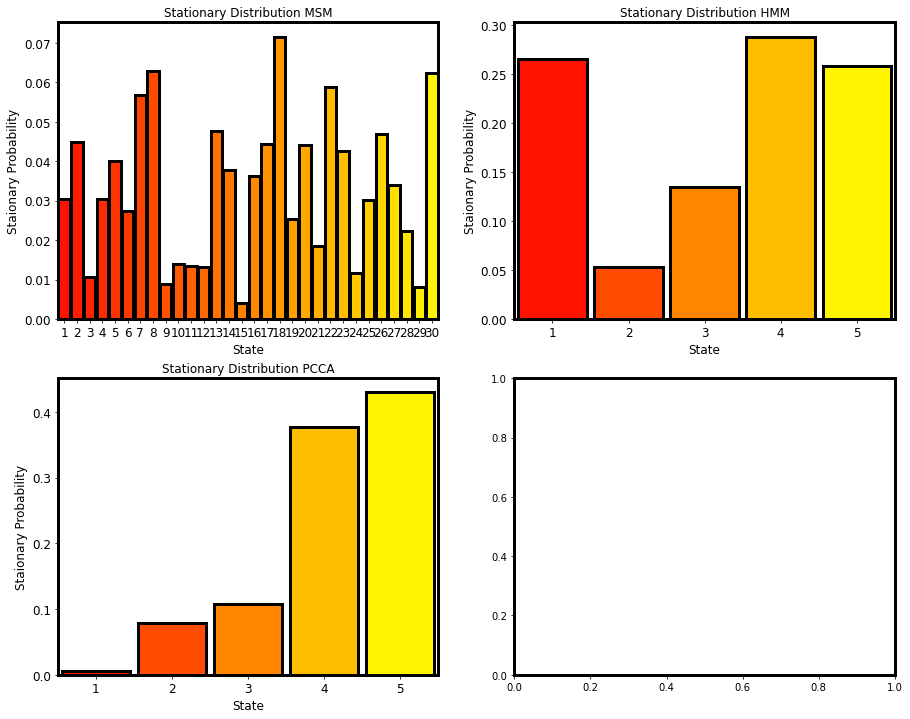

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [44]:
fig, axes = plt.subplots(2,2, figsize=(15,12))
for model, ax in zip("msm,hmm,pcca".split(","), axes.flat):
    plt.figure()
    msm.stationary_distribution(msm = model,
                                ax=ax,
                                cmap="autumn_r")
plt.tight_layout()

 # HMM CK-Test

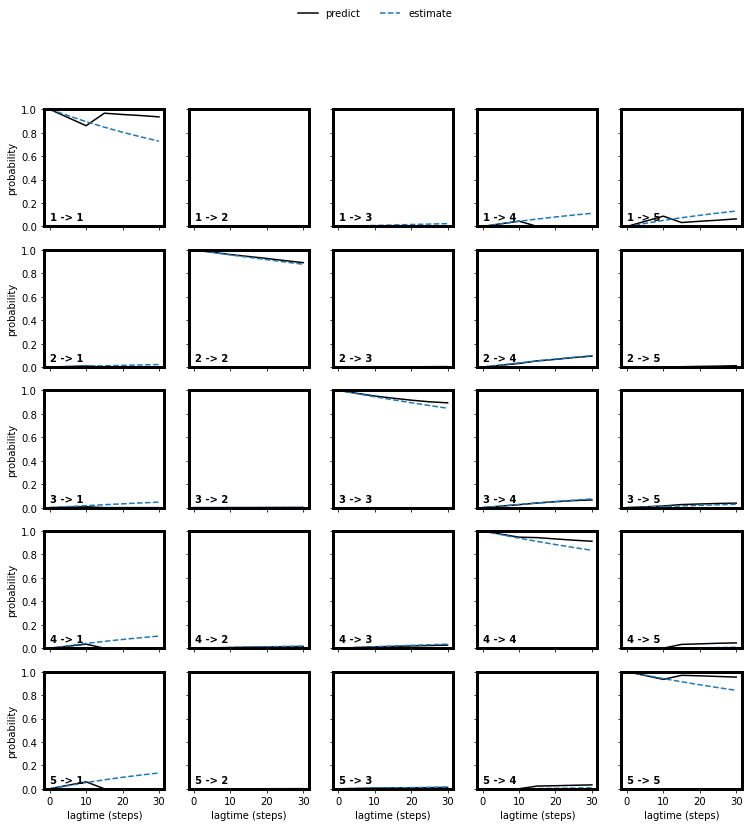

In [45]:
msm.cktest("hmm")

In [343]:
ck = msm.hmm[0].ck_test(msm.hmm[1:])

In [344]:
predictions, estimates = ck.predictions, ck.estimates

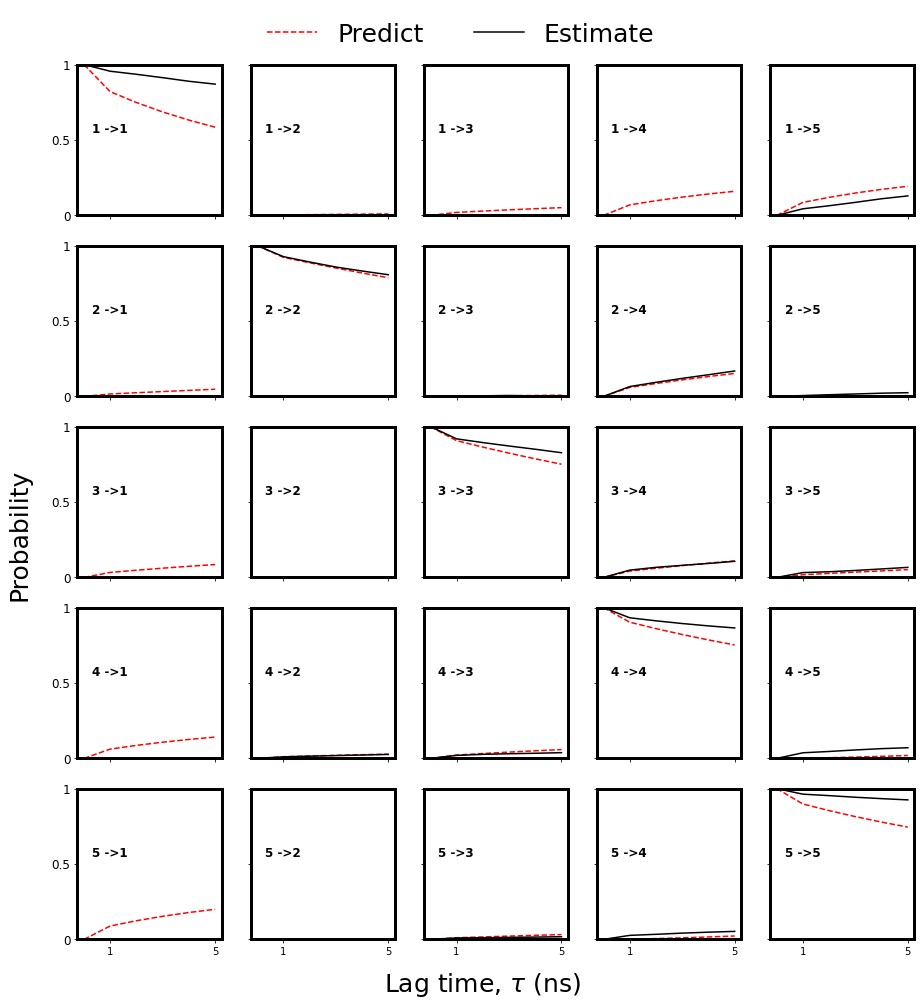

In [371]:
plot_cktest(predict = np.real(predictions), estimate = np.real(estimates), lag=1,dt=1)

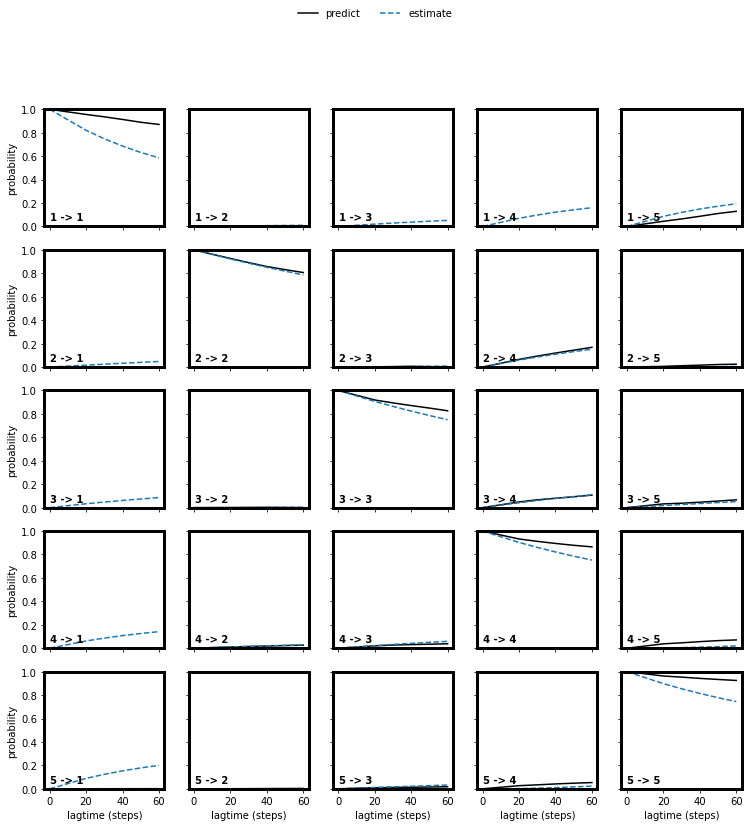

In [322]:
fig = msm.cktest(msm = "hmm", n_metastable_sets=6)

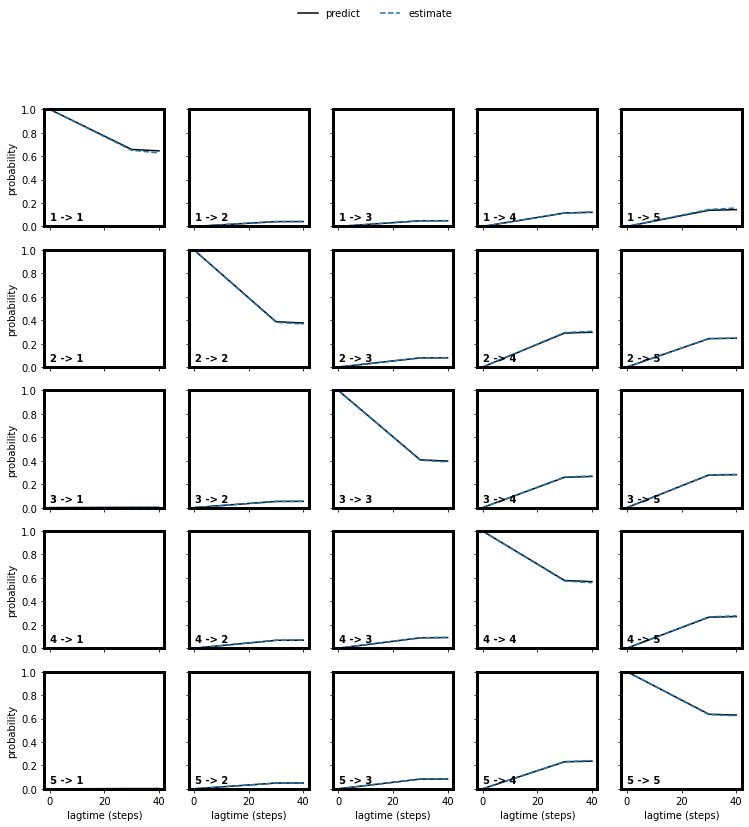

In [66]:
msm.cktest("pcca", 5)

 # Let's try a geometrically perfect helix

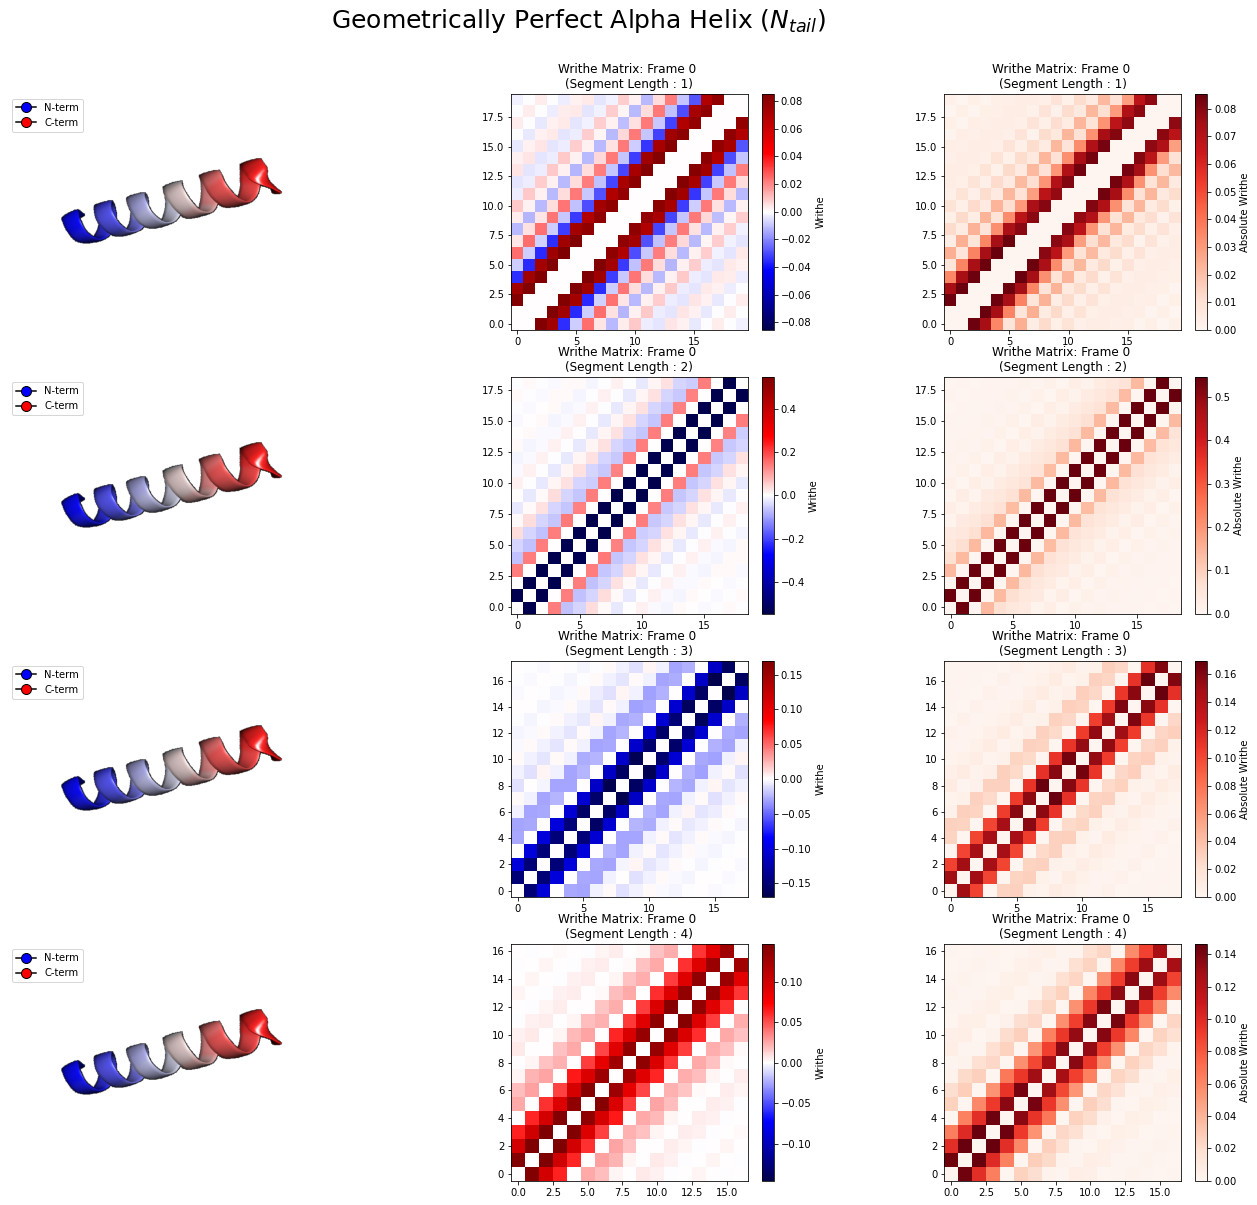

In [17]:
helix = md.load("./Ntail.helix.pdb")
#get CA coords
xyz_helix = helix.atom_slice(helix.topology.select("name CA")).xyz
#instantiate writhe class
writhe_helix = Writhe(xyz_helix)
#compute writhe at segment length : 4 (uses parallelization over the cpu cores)

fig,axes=plt.subplots(4,3, figsize=(22,20))
structure=visualize.make_structures(trj=helix, indices=0, dir="./ntail_helix/images")

fig.suptitle('Geometrically Perfect Alpha Helix ($N_{tail}$)', fontsize=25, y=.94)
for ax, segment_length in zip(axes, [1,2,3,4]):
    writhe_data = writhe_helix.compute_writhe(length = segment_length,
                                matrix = True,
                                store_results = True,
                                return_segments=False,
                                adj_matrix=False)
    visualize.plot_structure(image=structure, ax=ax[0])
    writhe_helix.plot_writhe_matrix(index=0, ax=ax[1])
    writhe_helix.plot_writhe_matrix(index=0, ax=ax[2], absolute=True)

 # Make Graph Representations For All Frames of The Trajectory

In [7]:
#make instance of writhe graph
graph = WritheGraph(trj)

#add edge features
graph.add_dihedrals() #0,1
graph.add_angles() #2,3
graph.add_intra_distances() #4
graph.add_writhe(segment_length = 1) #5
graph.add_writhe(segment_length = 3) #6
graph.add_writhe(segment_length = 5) #7

#add node_features
#graph.add_ligand_distances() #0
graph.add_dssp() #1
graph.add_rsa() #2

#set up
graph.make_edge_dict()

In [8]:
#make a graph for each frame
graphs = [graph.get_graph(i) for i in range(graph.nf)]

#set a directory to save to
root="./actr/graphs"
os.mkdir(root)

# GraphDataSet class collates all graph examples into one giant graph
# and stores them for efficient access during training

graph_dataset = GraphDataSet(root=root, name="graph", data_list=graphs)

Processing...
Done!


In [372]:
beta_values = np.arange(21)
np.savetxt("beta_values.txt", beta_values)

In [391]:
with open("beta_values.txt", "r") as file:
    f = "".join(file.readlines()).split(os.linesep)[:-1]